In [1]:
# import IPython
# IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel
# %load_ext autoreload
# %autoreload 2
import sys, math, datetime, time, torch, logging, json, dill
import progressbar as pb
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

from dqn_agent import DQNAgent
from double_dqn_agent import DoubleDQNAgent
from prioritized_replay_dqn_agent import PrioritizedReplayDQNAgent
from dueling_dqn_agent import DuelingDQNAgent


# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
log_file_path = 'output.log' # Output log file
algorithm = 'DQN'
# ['DQN','Double_DQN', 'Prioritized_Experience_Replay', 'Dueling_DQN']

logger = logging.getLogger('p1_navigation')
while logger.handlers:
    logger.removeHandler(logger.handlers[0])
logger.propagate = False

formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

sh = logging.StreamHandler(sys.stdout)
sh.setFormatter(formatter)
sh.setLevel(logging.DEBUG)

fh = logging.FileHandler(log_file_path)
fh.setLevel(logging.INFO)

logger.addHandler(sh)
logger.addHandler(fh)
logger.setLevel(logging.DEBUG)

logger.info('CUDA version: %s, CUDA enabled: %s' % (torch.version.cuda, torch.backends.cudnn.enabled))

The current device is cuda:0
2021-03-02 10:24:44,521 INFO CUDA version: 11.0, CUDA enabled: True


In [2]:
env = UnityEnvironment(file_name='Banana_Windows_x86_64\Banana.exe')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


# Initialize training

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
logger.debug('Number of agents: %i' % len(env_info.agents))

# examine the state space 
state = env_info.vector_observations[0]
logger.debug('States look like: %s' % state)
state_size = len(state)

# number of actions
action_size = brain.vector_action_space_size
logger.info('Number of agents: %i, states %i, actions: %i' % (len(env_info.agents), state_size, action_size))

if algorithm == 'DQN':
    from constants import CONSTANTS as C
    agent = DQNAgent(state_size, action_size)
elif algorithm == 'Double_DQN':
    from constants import CONSTANTS as C
    agent = DoubleDQNAgent(state_size, action_size)
elif algorithm == 'Prioritized_Experience_Replay':
    from constants import PRIORITIZED_REPLAY_CONSTANTS as C
    agent = PrioritizedReplayDQNAgent(state_size, action_size)
    beta = C['beta_begin']
    logger.info('It takes %f steps for beta to go from %f to %f' % ((C['beta_stable']-C['beta_begin'])/C['beta_increase'], C['beta_begin'], C['beta_stable']))
elif algorithm == 'Dueling_DQN':
    from constants import CONSTANTS as C
    agent = DuelingDQNAgent(state_size, action_size)
else:
    logger.warning('No algorithm specified')

logger.info(algorithm)
logger.info(json.dumps(C, indent=4))

episode_score_hist = []
total_score = 0

epsilon = C['epsilon_begin']
logger.info('It takes %f steps for epsilon to go from %f to %f' % (math.log(C['epsilon_stable']/C['epsilon_begin'], C['epsilon_decay']), C['epsilon_begin'], C['epsilon_stable']))


2021-03-02 10:25:25,308 DEBUG Number of agents: 1
2021-03-02 10:25:25,310 DEBUG States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
2021-03-02 10:25:25,311 INFO Number of agents: 1, states 37, actions: 4
Regular network created
Regular network created
2021-03-02 10:25:29,448 INFO DQN
2021-03-02 10:25:29,453 INFO {
    "hidden_layer_size": 128,
    "random_seed": 2,
    "learning_rate": 0.01,
    "tau": 0.1,
    "gamma": 0.99,
    "memory_size": 1000,
    "update_interval": 4,
    "sample_size": 64,
    "num_episodes": 2000,
    "epsilon_begin": 1,
    "epsilon_stable": 0.01,
    "epsilon_decay": 0.9977000638225533
}
2021-03-02 10:25:29,455 INFO It tak

Training

In [4]:
widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=C['num_episodes']).start()
start_time = time.time()
step = 0
for i in range(C['num_episodes'] + 1):
    env_info = env.reset(train_mode=True)[brain_name]  # reset the env at each episode
    state = agent.preprocessing(env_info.vector_observations[0])
    done = False
    episode_score = 0                                  # initialize the score
    while not done:
        if algorithm == 'Prioritized Experience Replay':
            action = agent.action(state, epsilon=epsilon, beta=beta)          # select an action
            beta = min(beta+C['beta_increase'], C['beta_stable'])
        else:
            action = agent.action(state, epsilon=epsilon)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = agent.preprocessing(env_info.vector_observations[0])   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        agent.replay_memory.add(state, action, reward, next_state, done)
        step += 1
#         logger.info('step, action, reward:%i, %i, %i' % (step, action, reward))
        episode_score += reward                        # update the score
        state = next_state                             # roll over the state to next time step
    total_score += episode_score
    episode_score_hist.append(episode_score)
    epsilon = max(epsilon*C['epsilon_decay'], C['epsilon_stable'])
    timer.update(i)
    if i % 100 == 0:
        logger.info('For episode %i, the average score is %.2f, episode history %s' % (i, total_score/100, episode_score_hist[-100:]))
        total_score = 0
timer.finish()
logger.info('The training completes in %f mins' % ((time.time() - start_time)/60))

2021-03-02 01:02:46,891 INFO For episode 0, the average score is 0.00, episode history [0.0]
2021-03-02 01:07:36,440 INFO For episode 100, the average score is -0.11, episode history [3.0, -1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, -2.0, 0.0, 2.0, -1.0, -1.0, 0.0, 1.0, 0.0, 1.0, -1.0, -1.0, 0.0, 1.0, 0.0, -1.0, -1.0, 1.0, 1.0, 0.0, 1.0, -1.0, 1.0, 0.0, -2.0, -1.0, 0.0, -2.0, 1.0, -1.0, -1.0, 0.0, 0.0, 1.0, -1.0, 1.0, 2.0, 0.0, 0.0, -3.0, 0.0, -3.0, -2.0, 0.0, 1.0, -1.0, -2.0, -1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, -2.0, 2.0, 0.0, 1.0, -2.0, 0.0, -1.0, 0.0, -1.0, 2.0, -1.0, 1.0, -1.0, 0.0, -2.0, 0.0, -2.0, 1.0, 0.0, 0.0, 2.0, 0.0, -1.0, 2.0, 0.0, 0.0, 1.0, 2.0]
2021-03-02 01:13:12,240 INFO For episode 200, the average score is 0.30, episode history [2.0, 0.0, -1.0, 3.0, 1.0, 0.0, -1.0, 1.0, 2.0, -1.0, 2.0, 0.0, 1.0, -1.0, -1.0, 0.0, 2.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 2.0, -1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, -2.0, 2.0, -2.0, -1.0, 0.0, 0.

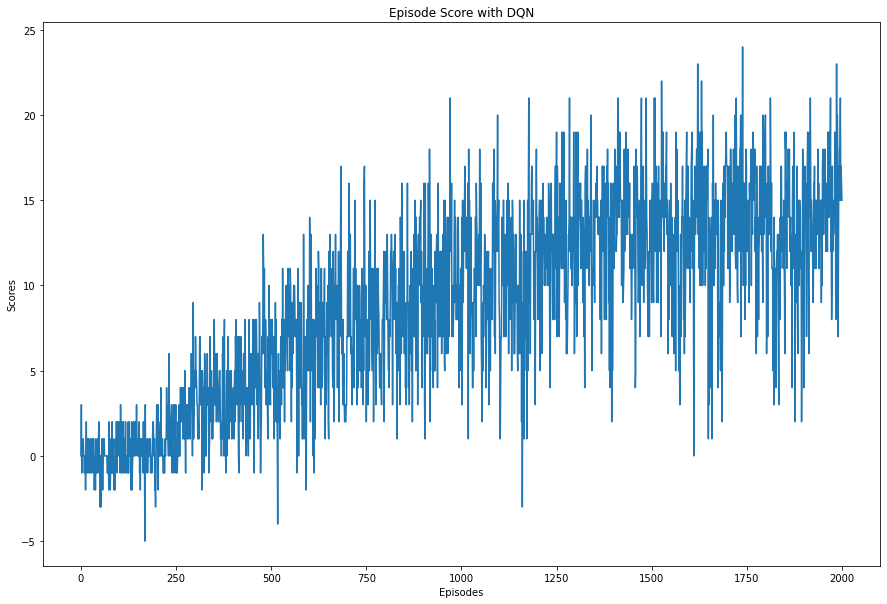

In [5]:
current_time = datetime.datetime.today().strftime("%Y%m%d_%H%M%S")
plt.figure(figsize=(15, 10))
plt.plot(episode_score_hist)
plt.title('Episode Score with %s' % algorithm)
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.savefig('plot/episode_score_%s_%s.png' % (algorithm, current_time), bbox_inches='tight')

In [6]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = agent.preprocessing(env_info.vector_observations[0])            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.action(state, epsilon=epsilon, beta=0)                   # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = agent.preprocessing(env_info.vector_observations[0])   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

logger.info("Score: {}".format(score))

2021-03-02 02:45:04,617 INFO Score: 14.0


In [7]:
# save the model and results
checkpoint = {
    'constants': C,
    'step': step,
    'episode_score_hist': episode_score_hist,
    'total_score': total_score,
    'epsilon': epsilon,
    'network_state_dict': agent.network.state_dict(),
    'target_network_state_dict': agent.target_network.state_dict()
}
torch.save(checkpoint, 'save/%s_%s.model' % (algorithm, current_time))
with open('save/agent_memory_%s_%s.data' % (algorithm, current_time), 'wb') as output:
    dill.dump(agent.replay_memory, output)

# Load model weights from the checkpoint

In [5]:
if algorithm == 'DQN':
    from constants import CONSTANTS as C
    agent_demo = DQNAgent(state_size, action_size)
elif algorithm == 'Double_DQN':
    from constants import CONSTANTS as C
    agent_demo = DoubleDQNAgent(state_size, action_size)
elif algorithm == 'Prioritized_Experience_Replay':
    from constants import PRIORITIZED_REPLAY_CONSTANTS as C
    agent_demo = PrioritizedReplayDQNAgent(state_size, action_size)
    beta = C['beta_begin']
    logger.info('It takes %f steps for beta to go from %f to %f' % ((C['beta_stable']-C['beta_begin'])/C['beta_increase'], C['beta_begin'], C['beta_stable']))
elif algorithm == 'Dueling_DQN':
    from constants import CONSTANTS as C
    agent_demo = DuelingDQNAgent(state_size, action_size)
else:
    logger.warning('No algorithm specified')

checkpoint = torch.load('save\DQN_20210224_001230.model')
agent_demo.network.load_state_dict(checkpoint['network_state_dict'])
agent_demo.target_network.load_state_dict(checkpoint['target_network_state_dict'])
episode_score_hist = checkpoint['episode_score_hist']
del checkpoint

Regular network created
Regular network created


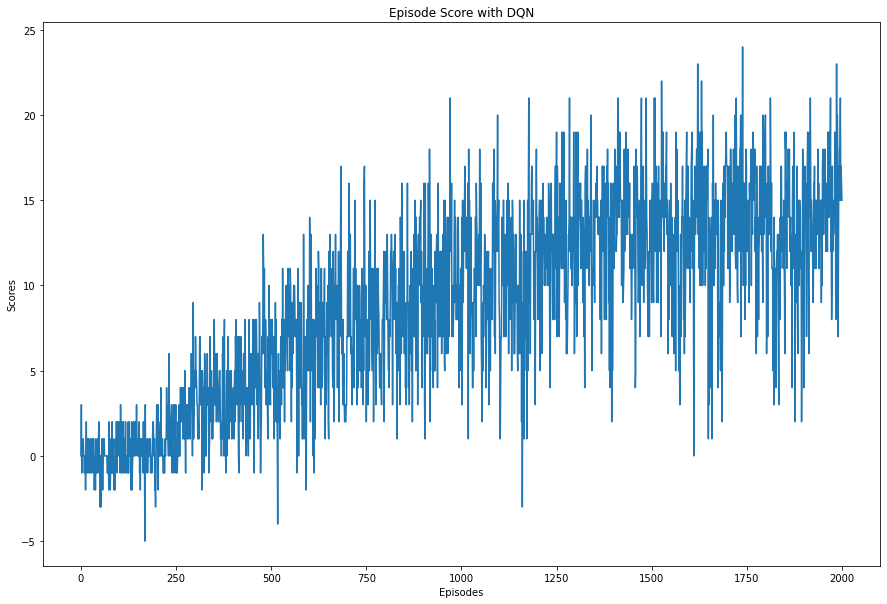

In [6]:
current_time = datetime.datetime.today().strftime("%Y%m%d_%H%M%S")
plt.figure(figsize=(15, 10))
plt.plot(episode_score_hist)
plt.title('Episode Score with %s' % algorithm)
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.savefig('plot/episode_score_%s_%s.png' % (algorithm, current_time), bbox_inches='tight')

In [11]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = agent_demo.preprocessing(env_info.vector_observations[0])            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent_demo.action(state, epsilon=epsilon, beta=0)                   # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = agent_demo.preprocessing(env_info.vector_observations[0])   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

logger.info("Score: {}".format(score))

2021-03-02 10:36:41,939 INFO Score: -1.0


In [ ]:
# env.close()